In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from import_lib.func import sphere, weierstrass, ackley, rosenbrock, schwefel, griewank, rastrigin
from import_lib.GA import population_init, factorial_cost, factorial_rank, skill_factor_best_task, polynomial_mutation, sbx_crossover
from import_lib.MFEA_Model import MFEA_base, MFEA1
from import_lib.benchmark import CEC17_benchmark_10tasks, GECCO20_benchmark_50tasks

In [2]:
tasks = CEC17_benchmark_10tasks()

In [3]:
print(tasks[0].func(tasks[0].encode(np.array([0] * 50))))
print(tasks[1].func(tasks[1].encode(np.array([80] * 50))))
print(tasks[2].func(tasks[2].encode(np.array([-80] * 50))))
print(tasks[3].func(tasks[3].encode(np.array([-0.4] * 25))))
print(tasks[4].func(tasks[4].encode(np.array([0] * 50))))
print(tasks[5].func(tasks[5].encode(np.array([40] * 50))))
print(tasks[6].func(tasks[6].encode(np.array([-0.4] * 50))))
print(tasks[7].func(tasks[7].encode(np.array([420.9687] * 50))))
print(tasks[8].func(tasks[8].encode(np.append(np.array([-80] * 25), np.array([80] * 25)))))
print(tasks[9].func(tasks[9].encode(np.append(np.array([40] * 25), np.array([-40] * 25)))))


0.0
0.0
0.0
0.0
0.0
4.440892098500626e-16
0.0
0.0006363918728311546
0.0
320000.0


In [4]:
tasks[1].decode(tasks[1].encode(np.array([80] * 50)))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [5]:
print(tasks[0].encode(np.array([0] * 50))[[0, -1]])
print(tasks[1].encode(np.array([80] * 50))[[0, -1]])
print(tasks[2].encode(np.array([-80] * 50))[[0, -1]])
print(tasks[3].encode(np.array([-0.4] * 25))[[0, -1]])
print(tasks[4].encode(np.array([0] * 50))[[0, -1]])
print(tasks[5].encode(np.array([40] * 50))[[0, -1]])
print(tasks[6].encode(np.array([-0.4] * 50))[[0, -1]])
print(tasks[7].encode(np.array([420.9687] * 50))[[0, -1]])
print(tasks[8].encode(np.append(np.array([-80] * 25), np.array([80] * 25)))[[0, -1]])
print(tasks[9].encode(np.append(np.array([40] * 25), np.array([-40] * 25)))[[0, -1]])

[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.51 0.51]
[0.5 0.5]
[0.5 0.5]
[0.9209687 0.9209687]
[0.5 0.5]
[ 1.3 -0.3]


In [6]:
fun = sphere(50,shift= 80,limited_space= True, lower_bound= -100, upper_bound= 100),   # 0
fun[0].encode(np.array([180] * 50))[[0, -1]]

array([1., 1.])

In [7]:
test_pop, test_ska = population_init(100, 3, 2)
print(test_pop.shape, test_ska.shape)

(300, 2) (300,)


In [8]:
sbx_crossover(np.array([0, 0, 0.3]), np.array([0.99, 1, 0.7]))

(array([0.       , 0.       , 0.3296219]),
 array([0.99344266, 1.        , 0.6703781 ]))

In [9]:
a = np.array([0, 1, 0.5], dtype= np.float)
print(polynomial_mutation(a, all_dimensions= False))


[0.  1.  0.5]


#### MFEA: SA AND LSA

In [10]:
def Success_History_Memory_Update(M, next_update_position_M, S, delta, K):

    for i in range(K):
        for j in range(i + 1, K):
            if len(S[i][j]) != 0:
                M[i, j][next_update_position_M[i, j]] =\
                    np.sum(np.array(delta[i][j]) * np.array(S[i][j])**2)/np.sum(np.array(delta[i][j]) * (np.array(S[i][j]))+ 1e-10)
                
                next_update_position_M[i, j] = (next_update_position_M[i, j] + 1) % M.shape[2]

    return M, next_update_position_M

In [11]:
def LSA_MFEA(MAXEVALS, num_inds_each_task, N_min = 50, tasks = [], nc = 2, nm = 5, H = 30, sigmoid = 0.1, 
            LSA = True, polynomial_all_gen = False):

    #save history of factorial cost
    history_cost = np.empty((0, len(tasks)), np.float)
    
    max_d = 0
    for t in tasks:
        if max_d < t.d:
            max_d = t.d

    N_max = num_inds_each_task
    maxEvals = MAXEVALS/len(tasks)
    eval_k = [0]*len(tasks)
    epoch = 0

    # initial population and skill_factor_arr
    population, skill_factor_arr = population_init(
        N = num_inds_each_task, 
        num_tasks = len(tasks), 
        d = max_d,
        min_val = 0,
        max_val = 1,
    )

    # get skill_factor for pop
    skill_factor_arr = skill_factor_best_task(population, tasks)
    population_factorial_cost = factorial_cost(population, skill_factor_arr, tasks)

    history_cost = np.append(history_cost, [[np.min(population_factorial_cost[np.where(skill_factor_arr == idx)[0]]) for idx in range (len(tasks))]], axis = 0)

    #Inittialize success history mem M
    M = np.ones((len(tasks), len(tasks), H)) / 2
    next_update_position_M = np.zeros((len(tasks), len(tasks)), dtype= np.int)

    # mean and sd of rmp each generations
    # len(task) * len(tasks) * generations * 2
    saved_rmp = np.array([[[[0.5, 0]]]* len(tasks)] * len(tasks)).tolist()

    while np.sum(eval_k) < MAXEVALS:

        S = np.empty((len(tasks), len(tasks), 0)).tolist()
        delta = np.empty((len(tasks), len(tasks), 0)).tolist()

        #initial offspring for epoch
        offspring = np.empty((0, max_d))
        offspring_skill_factor = np.empty((0, ), np.int)
        offspring_factorial_cost = np.empty((0, ), np.int)

        # his rmp of this generation
        rmp_this_gen = np.empty((len(tasks), len(tasks), 0)).tolist()

        while len(offspring_skill_factor) < len(population):
            #random 2 inds
            [idx_pa, idx_pb] = np.random.randint(len(population), size = 2)
            [pa, pb], [skf_pa, skf_pb] = population[[idx_pa, idx_pb]], skill_factor_arr[[idx_pa, idx_pb]]    

            if skf_pa == skf_pb:
                oa, ob = sbx_crossover(pa, pb, nc)

                oa = polynomial_mutation(oa,nm, polynomial_all_gen)
                ob = polynomial_mutation(ob,nm, polynomial_all_gen)
                
                skf_oa, skf_ob = skf_pa, skf_pa

                # Evaluate oa, ob
                fcost_oa, fcost_ob = tasks[skf_oa].func(oa), tasks[skf_ob].func(ob)
                eval_k[skf_oa] += 1
                eval_k[skf_ob] += 1
            else:
                #swap
                if skf_pa > skf_pb: 
                    pa, pb = pb, pa
                    skf_pa, skf_pb = skf_pb, skf_pa

                # caculate rmp
                mu = np.random.choice(M[skf_pa, skf_pb])
                rmp = np.random.normal(mu, sigmoid)
                if rmp < 0: rmp = 0
                if rmp > 1: rmp = 1

                # save generation's rmp
                rmp_this_gen[skf_pa][skf_pb].append(rmp)

                # Inter-task crossover
                if np.random.uniform() < rmp:
                    oa, ob = sbx_crossover(pa, pb, nc)

                    oa = polynomial_mutation(oa,nm, polynomial_all_gen)
                    ob = polynomial_mutation(ob,nm, polynomial_all_gen)
                    
                    skf_oa, skf_ob = np.random.choice([skf_pa, skf_pb], replace=True, size = 2)
                else:
                    # select pa' and pb'
                    idx_pa2 = np.random.choice(np.where(skill_factor_arr == skf_pa)[0])
                    idx_pb2 = np.random.choice(np.where(skill_factor_arr == skf_pb)[0])
                    pa2 = population[idx_pa2]
                    pb2 = population[idx_pb2]

                    oa, _ = sbx_crossover(pa, pa2)
                    ob, _ = sbx_crossover(pb, pb2)

                    oa = polynomial_mutation(oa,nm, polynomial_all_gen)
                    ob = polynomial_mutation(ob,nm, polynomial_all_gen)

                    skf_oa, skf_ob = skf_pa, skf_pb
                
                # Evaluate oa, ob
                fcost_oa, fcost_ob = tasks[skf_oa].func(oa), tasks[skf_ob].func(ob)
                eval_k[skf_oa] += 1
                eval_k[skf_ob] += 1

                # Caculate the maximum imporvement percentage
                Delta = 0
                if (skf_oa == skf_pa):
                    Delta = max(Delta, 
                        (population_factorial_cost[idx_pa] - fcost_oa)/population_factorial_cost[idx_pa]
                    )
                else:
                    Delta = max(Delta, 
                        (population_factorial_cost[idx_pb] - fcost_oa)/population_factorial_cost[idx_pb]
                    )
                if (skf_ob == skf_pa):
                    Delta = max(Delta, 
                        (population_factorial_cost[idx_pa] - fcost_ob)/population_factorial_cost[idx_pa]
                    )
                else:
                    Delta = max(Delta, 
                        (population_factorial_cost[idx_pb] - fcost_ob)/population_factorial_cost[idx_pb]
                    )

                if Delta > 0:
                    S[skf_pa][skf_pb].append(rmp)
                    delta[skf_pa][skf_pb].append(Delta)

            offspring = np.append(offspring, [oa, ob], axis = 0)
            offspring_skill_factor = np.append(offspring_skill_factor, [skf_oa, skf_ob])
            offspring_factorial_cost = np.append(offspring_factorial_cost, [fcost_oa, fcost_ob])
        
        M, next_update_position_M = Success_History_Memory_Update(M, next_update_position_M, S, delta, K = len(tasks))

        # update pop
        population = np.append(population, offspring, axis = 0)
        skill_factor_arr = np.append(skill_factor_arr, offspring_skill_factor, axis = 0)
        population_factorial_cost = np.append(population_factorial_cost, offspring_factorial_cost, axis = 0)

        # Linear_Population_Size_Reduction_Strategy 
        idx_selected_inds = np.empty((0,),dtype=int)
        scalar_fitness = 1/factorial_rank(population_factorial_cost, skill_factor_arr, len(tasks))
        for i in range(len(tasks)): 
            if LSA :
                N_i = int(min(N_max - eval_k[i]/maxEvals * (N_max - N_min), len(np.where(skill_factor_arr == i)[0])))
            else:
                N_i = num_inds_each_task
            ind_task_i = np.where(skill_factor_arr == i)[0]
            sort_idx = ind_task_i[np.argsort(- scalar_fitness[ind_task_i])]
            idx_selected_inds = np.append(idx_selected_inds, sort_idx[:N_i], axis = 0)
        
        population = population[idx_selected_inds]
        skill_factor_arr = skill_factor_arr[idx_selected_inds]
        population_factorial_cost = population_factorial_cost[idx_selected_inds]

        #save history
        history_cost = np.append(history_cost, [[np.min(population_factorial_cost[np.where(skill_factor_arr == idx)[0]]) for idx in range (len(tasks))]], axis = 0)
        
        #save mu and sigmoid rmp
        for i in range (len(tasks)):
            for j in range (i + 1, len(tasks)):
                if len(rmp_this_gen[i][j]) != 0:
                    mu = np.mean(rmp_this_gen[i][j])
                    sd = np.std(rmp_this_gen[i][j])
                    saved_rmp[i][j].append([mu, sd])

        #print
        sys.stdout.write('\r')
        sys.stdout.write('Epoch {}, [%-20s] %3d%% ,pop_size: {}, func_val: {}'
            .format(epoch + 1, len(population),[np.min(population_factorial_cost[np.where(skill_factor_arr == idx)[0]]) for idx in range (len(tasks))])
            % ('=' * ((np.sum(eval_k) + 1) // (MAXEVALS // 20)) + '>' , (np.sum(eval_k) + 1) * 100 // MAXEVALS)
            )
        sys.stdout.flush()

        epoch += 1

    #find solve
    sol_idx = [np.argmin(population_factorial_cost[np.where(skill_factor_arr == idx)]) for idx in range (len(tasks))]
    sol = [task.decode(population[np.where(skill_factor_arr == idx)][sol_idx[idx]]) for idx, task in enumerate(tasks)]

    return sol, history_cost, np.array(saved_rmp)

In [12]:
mfea_sol, mfea_his = MFEA_base(num_epochs= 1000, num_inds_each_task= 100, tasks = tasks,
                        rmp = 0.3, nc = 2, nm = 5, evaluate_initial_skillFactor= True,
                        one_line=False, num_epochs_printed=10 )

np.save(file = "./RESULTS/mfea_base_his_CEC17.npy", arr = mfea_his )

Epoch [100/1000], [==>                 ]  10% ,func_val: [14395.189858210766, 12926.693370321469, 13692.95260792128, 13.912290881239592, 61292564.524819575, 17.820202303152666, 43.37651263345907, 10058.535399229258, 4.5587984758751166, 3559.5739141841314]

Epoch [200/1000], [====>               ]  20% ,func_val: [1828.0730630043072, 1890.0831016629058, 1911.3114364538046, 5.719742220286605, 1108878.804361354, 10.69045684920879, 26.645296292789638, 8036.608925505938, 1.490455386936035, 852.9498540253562]

Epoch [300/1000], [======>             ]  30% ,func_val: [330.2207461405865, 326.9077273308598, 351.65969369957315, 2.783098813036929, 42363.80845111296, 6.205244069112879, 15.393859645006714, 6589.933151560321, 1.0819737978857438, 374.4784166197644]

Epoch [400/1000], [========>           ]  40% ,func_val: [84.28655384954098, 85.19739146318923, 84.53366123778632, 1.9326469859320738, 5119.1311787526, 3.9726576411893118, 9.772042907999378, 5447.259045923687, 0.9914801427825306, 246.7328

In [13]:
sa_sol, sa_his, sa_rmp_his = LSA_MFEA(100000 * len(tasks), LSA = False, num_inds_each_task= 100, tasks= tasks,
                                    nc = 2, nm = 5, H = 30, sigmoid= 0.1)

np.save(file = "./RESULTS/sa_his_CEC17.npy", arr = sa_his)
np.save(file = "./RESULTS/sa_rmp_his_CEC17.npy", arr = sa_rmp_his )

Epoch 1000, [====================>] 100% ,pop_size: 1000, func_val: [2.9627662158888675, 3.147833195194835, 3.175531002547528, 0.6806090892821643, 121.76351369026085, 1.135995290798388, 3.390214831119522, 4942.647208383281, 0.07439162498306562, 112.648133523875]7]]]

/tmp/ipykernel_399610/35088251.py:188: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return sol, history_cost, np.array(saved_rmp)


In [14]:
lsa_sol, lsa_his, lsa_rmp_his = LSA_MFEA(80000 * len(tasks), num_inds_each_task= 100, tasks= tasks, 
                                        nc = 2, nm = 5, H = 30, sigmoid= 0.1)
np.save(file = "./RESULTS/lsa_his_CEC17.npy", arr = lsa_his)
np.save(file = "./RESULTS/lsa_rmp_his_CEC17.npy", arr = lsa_rmp_his )

Epoch 1117, [====================>] 100% ,pop_size: 494, func_val: [0.9058640971322325, 0.8729871659564875, 0.892888317582879, 0.39853006679344816, 71.79179288608393, 0.4849408378236153, 2.224607331381975, 3939.963135441267, 0.018437521036777205, 75.50647689630392]2]

/tmp/ipykernel_399610/35088251.py:188: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return sol, history_cost, np.array(saved_rmp)


In [15]:
mfea_his = np.load(file = "./RESULTS/mfea_base_his_CEC17.npy")

sa_his = np.load(file = "./RESULTS/sa_his_CEC17.npy")
sa_rmp_his  = np.load(file = "./RESULTS/sa_rmp_his_CEC17.npy", allow_pickle= True)

lsa_his = np.load(file = "./RESULTS/lsa_his_CEC17.npy")
lsa_rmp_his  = np.load(file = "./RESULTS/lsa_rmp_his_CEC17.npy", allow_pickle= True)

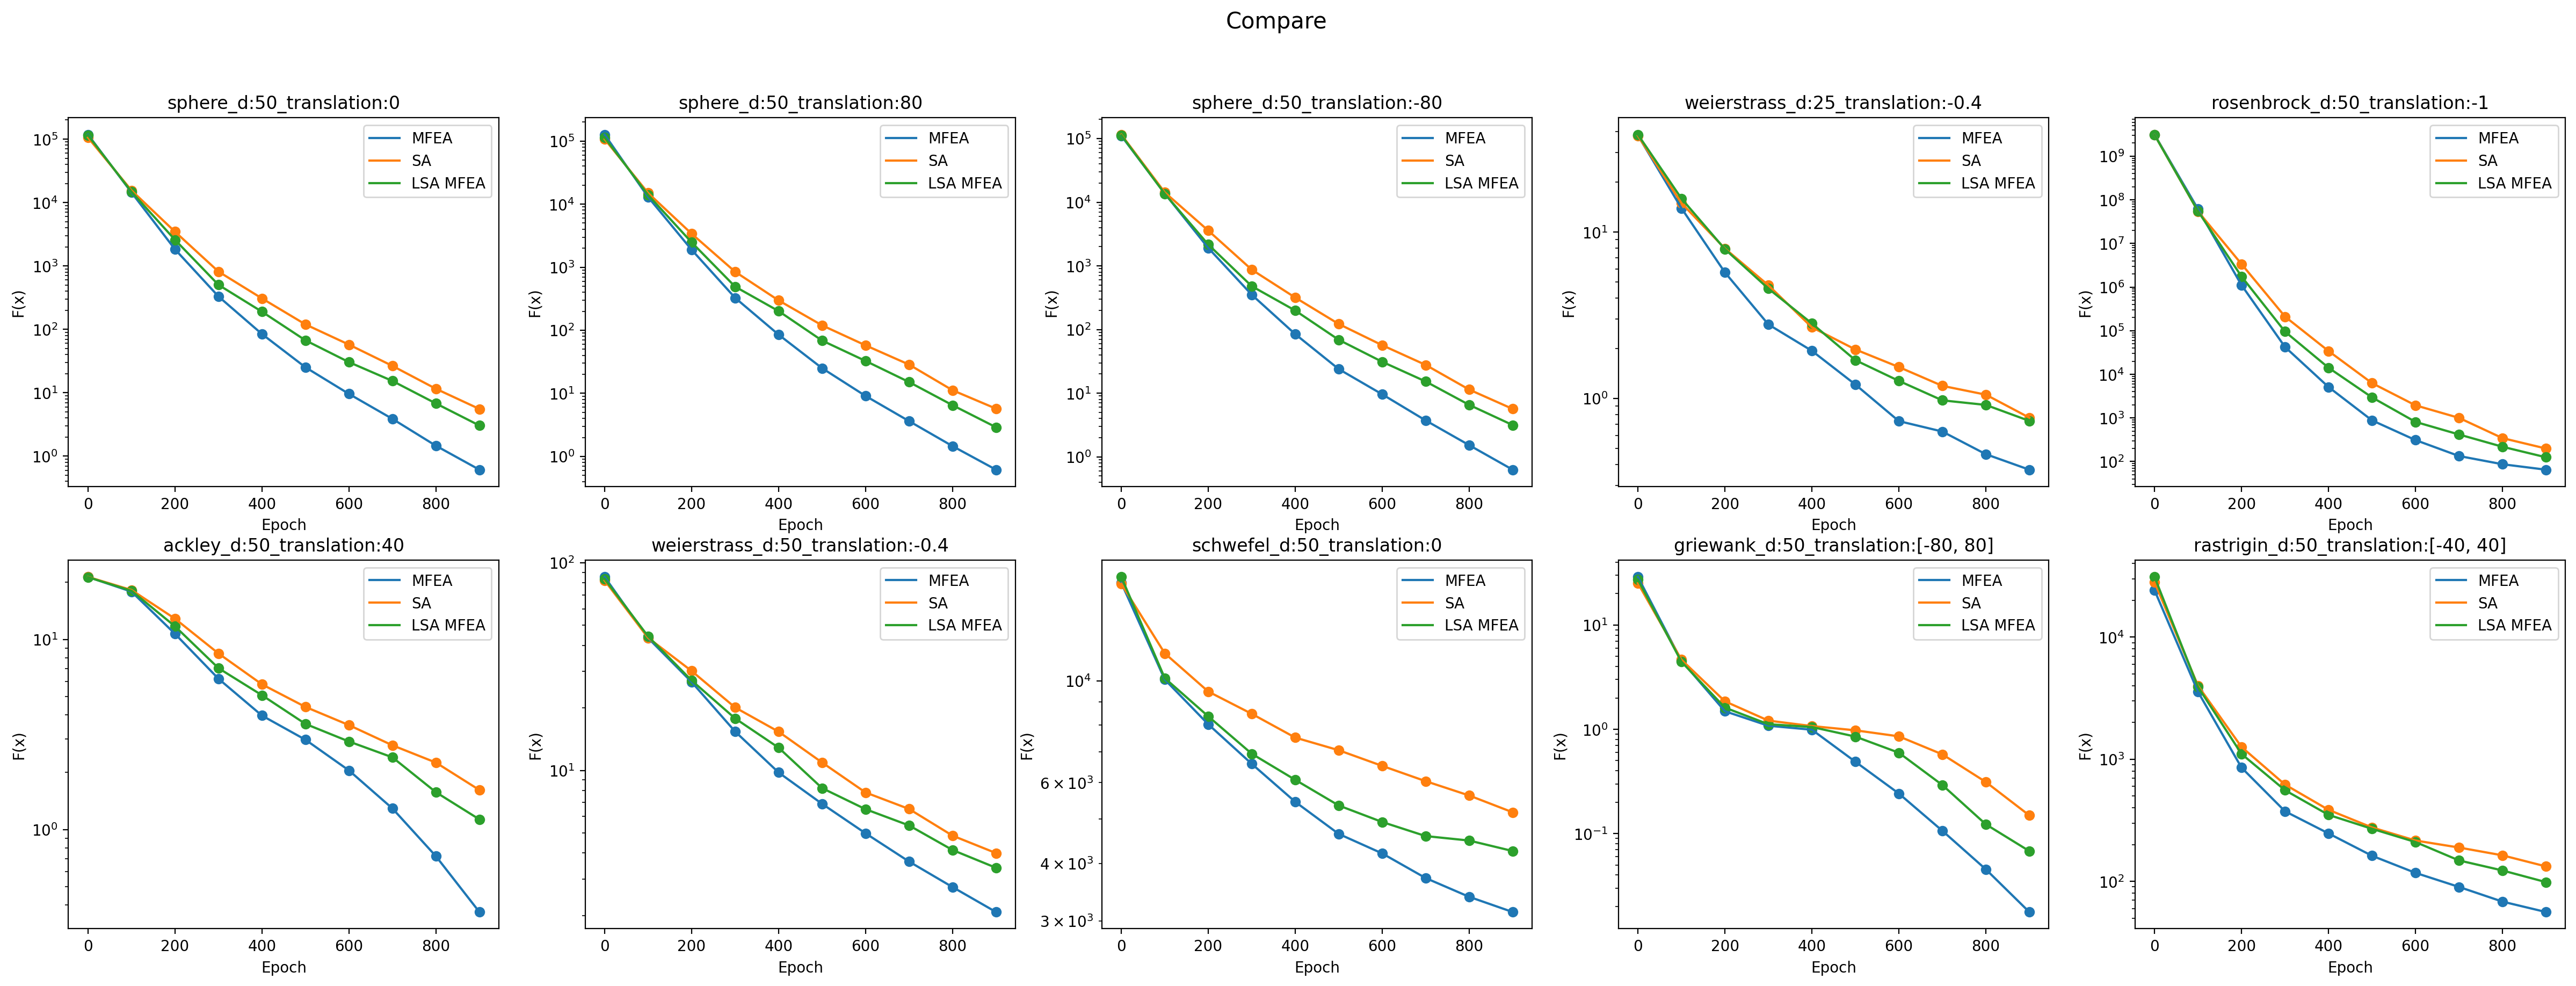

In [16]:
fig = plt.figure(figsize = (30, 10), dpi= 200)
fig.suptitle("Compare\n", size = 15)
fig.set_facecolor("white")

label_legend = ["MFEA", "SA", "LSA MFEA"]

for i in range (len(tasks)):
    for idx, sub_his in enumerate([mfea_his, sa_his, lsa_his]): 
        plt.subplot(2, int(len(tasks) / 2), i + 1)

        plt.plot(np.arange(0, 1000, 100), sub_his[np.arange(0, 1000, 100), i], label= label_legend[idx])
        plt.scatter(np.arange(0, 1000, 100), sub_his[np.arange(0, 1000, 100), i])
        plt.legend()

    plt.title(tasks[i].name)
    plt.xlabel("Epoch")
    plt.ylabel("F(x)")
    plt.yscale("log")

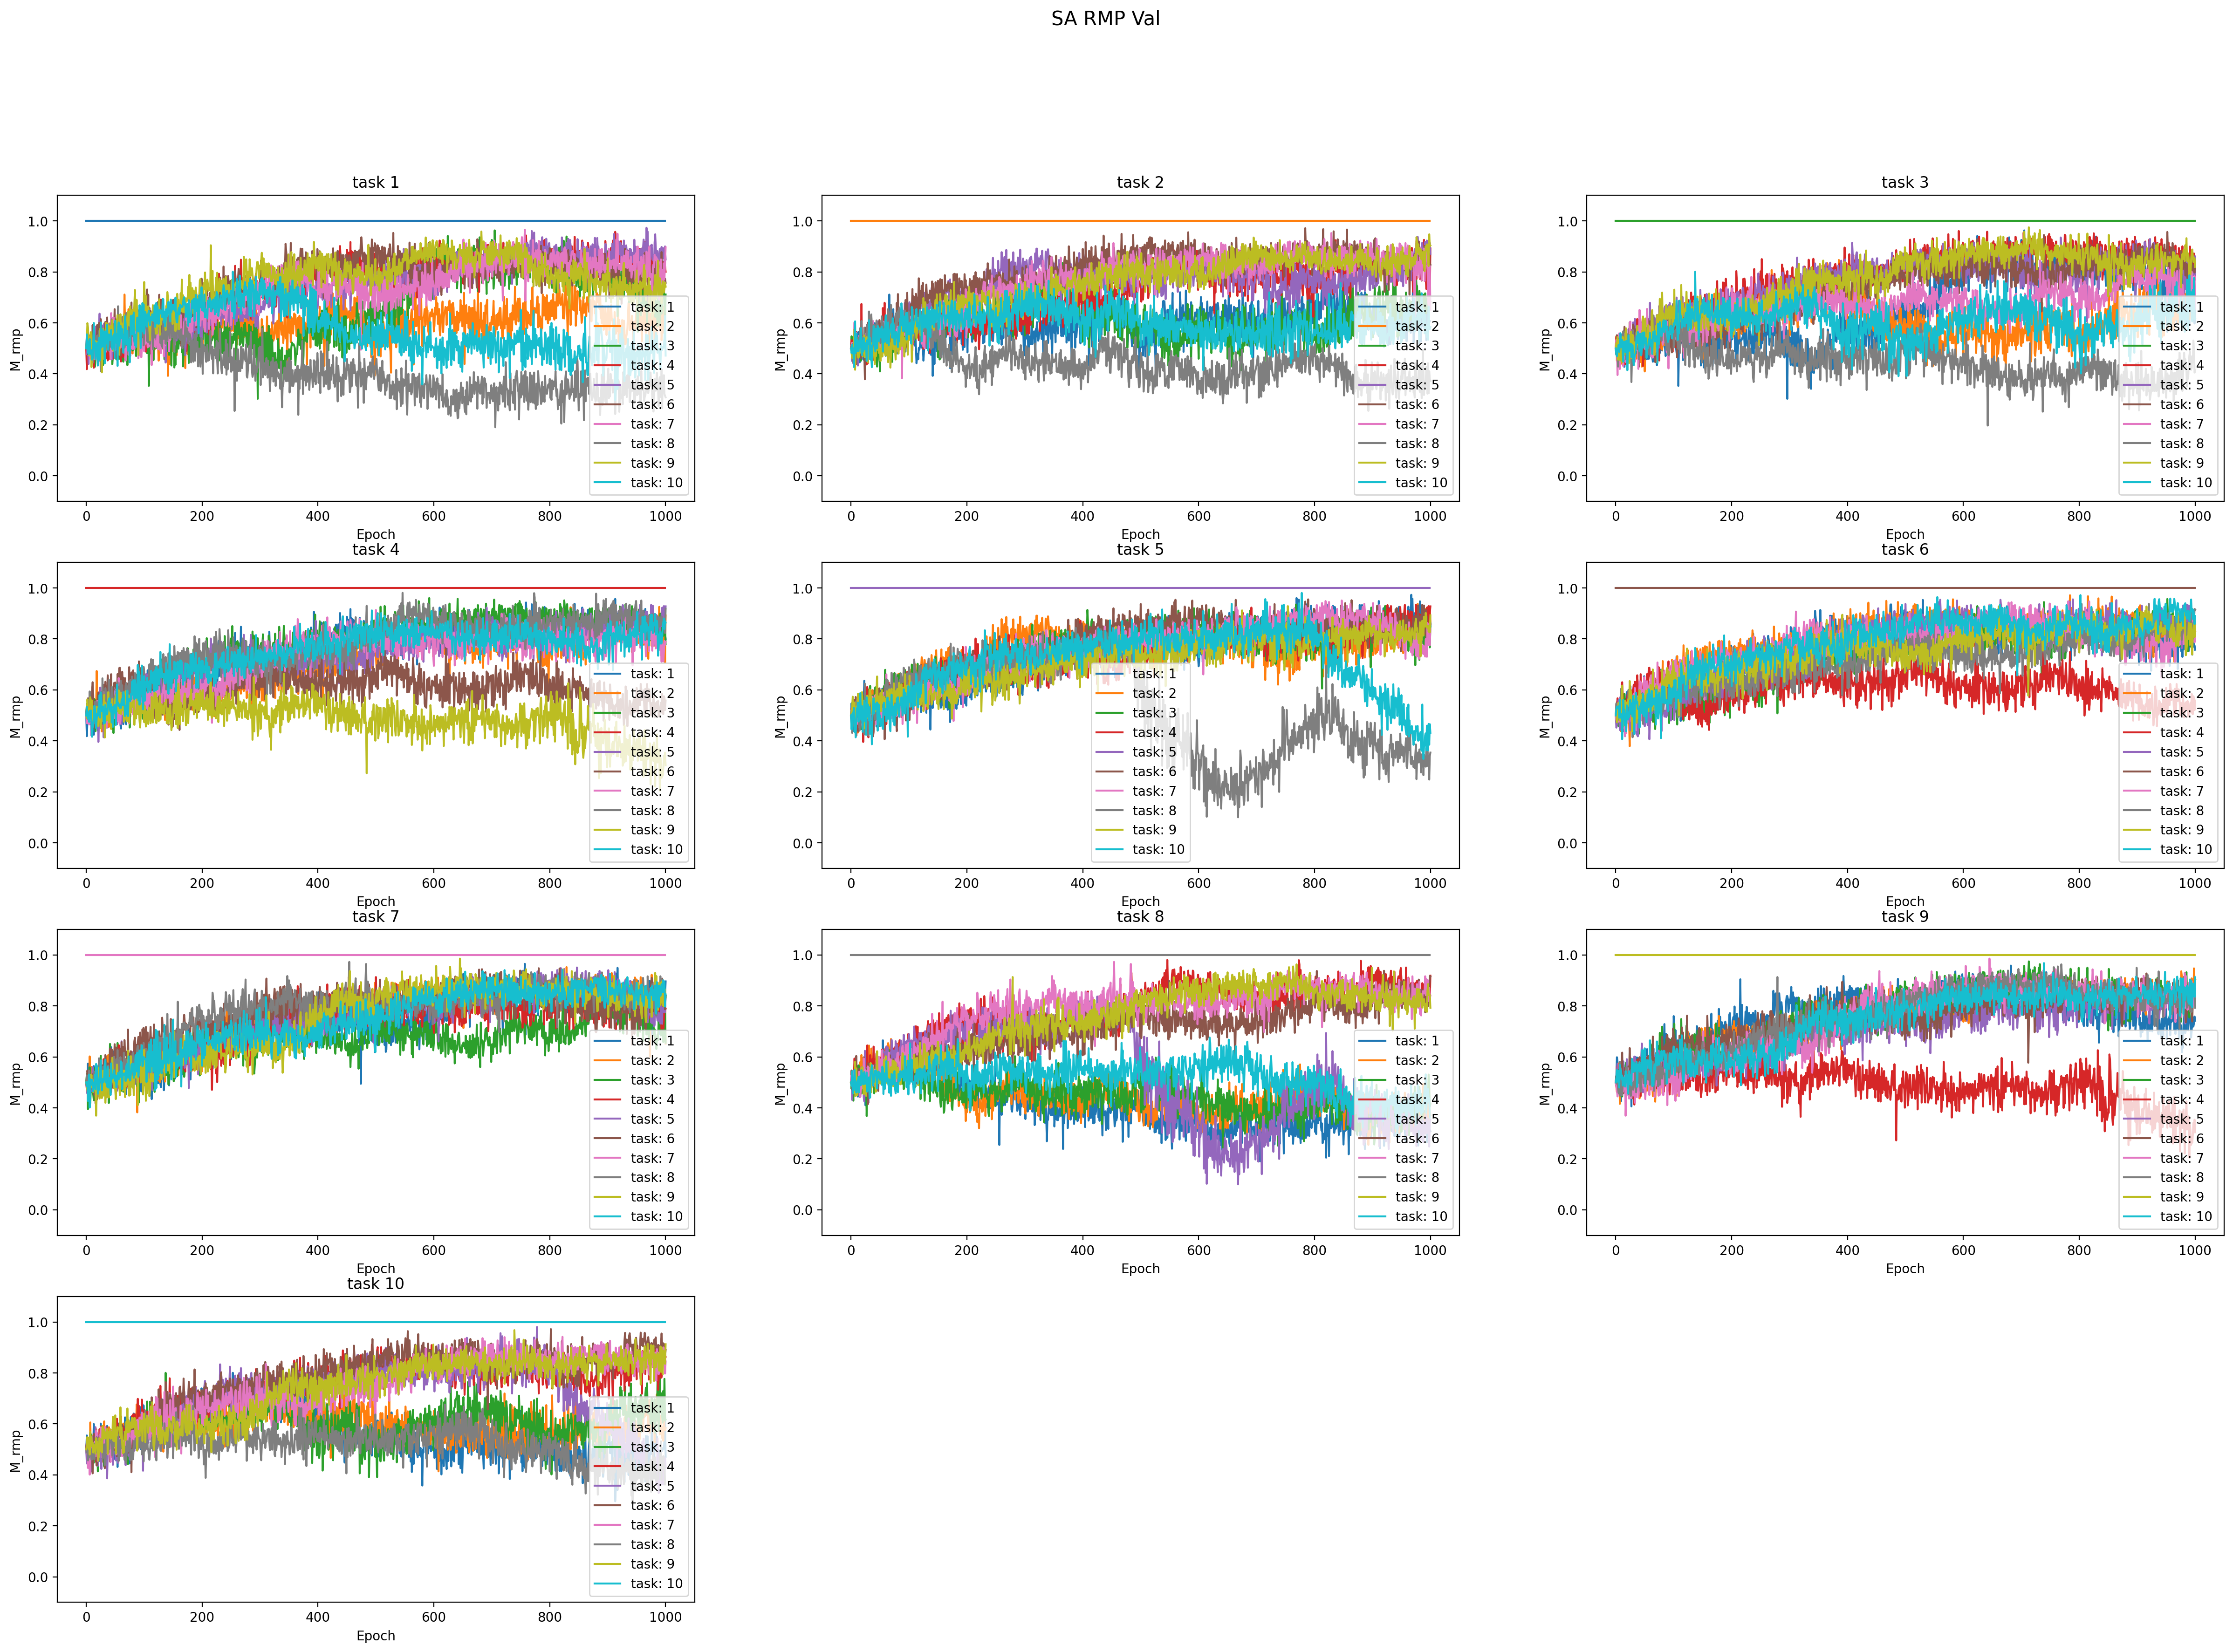

In [17]:
fig = plt.figure(figsize = (30, 20), dpi= 200)
fig.suptitle("SA RMP Val\n", size = 15)
fig.set_facecolor("white")

for i in range (len(tasks)):
    for j in range (len(tasks)):
        r, c = min(i, j), max(i, j)
        if i != j: 
            plt.subplot(int(np.ceil(len(tasks) / 3)), 3, i + 1)
            plt.plot(np.arange(len(sa_rmp_his[r][c])), np.array(sa_rmp_his[r][c])[:, 0], label= 'task: ' +str(j + 1))
            plt.legend()
        else:
            plt.subplot(int(np.ceil(len(tasks) / 3)), 3, i + 1)
            plt.plot(np.arange(1000), np.ones_like(np.arange(1000)), label= 'task: ' +str(j + 1))
            plt.legend()




    plt.title('task ' + str( i + 1))
    plt.xlabel("Epoch")
    plt.ylabel("M_rmp")
    plt.ylim(bottom = -0.1, top = 1.1)


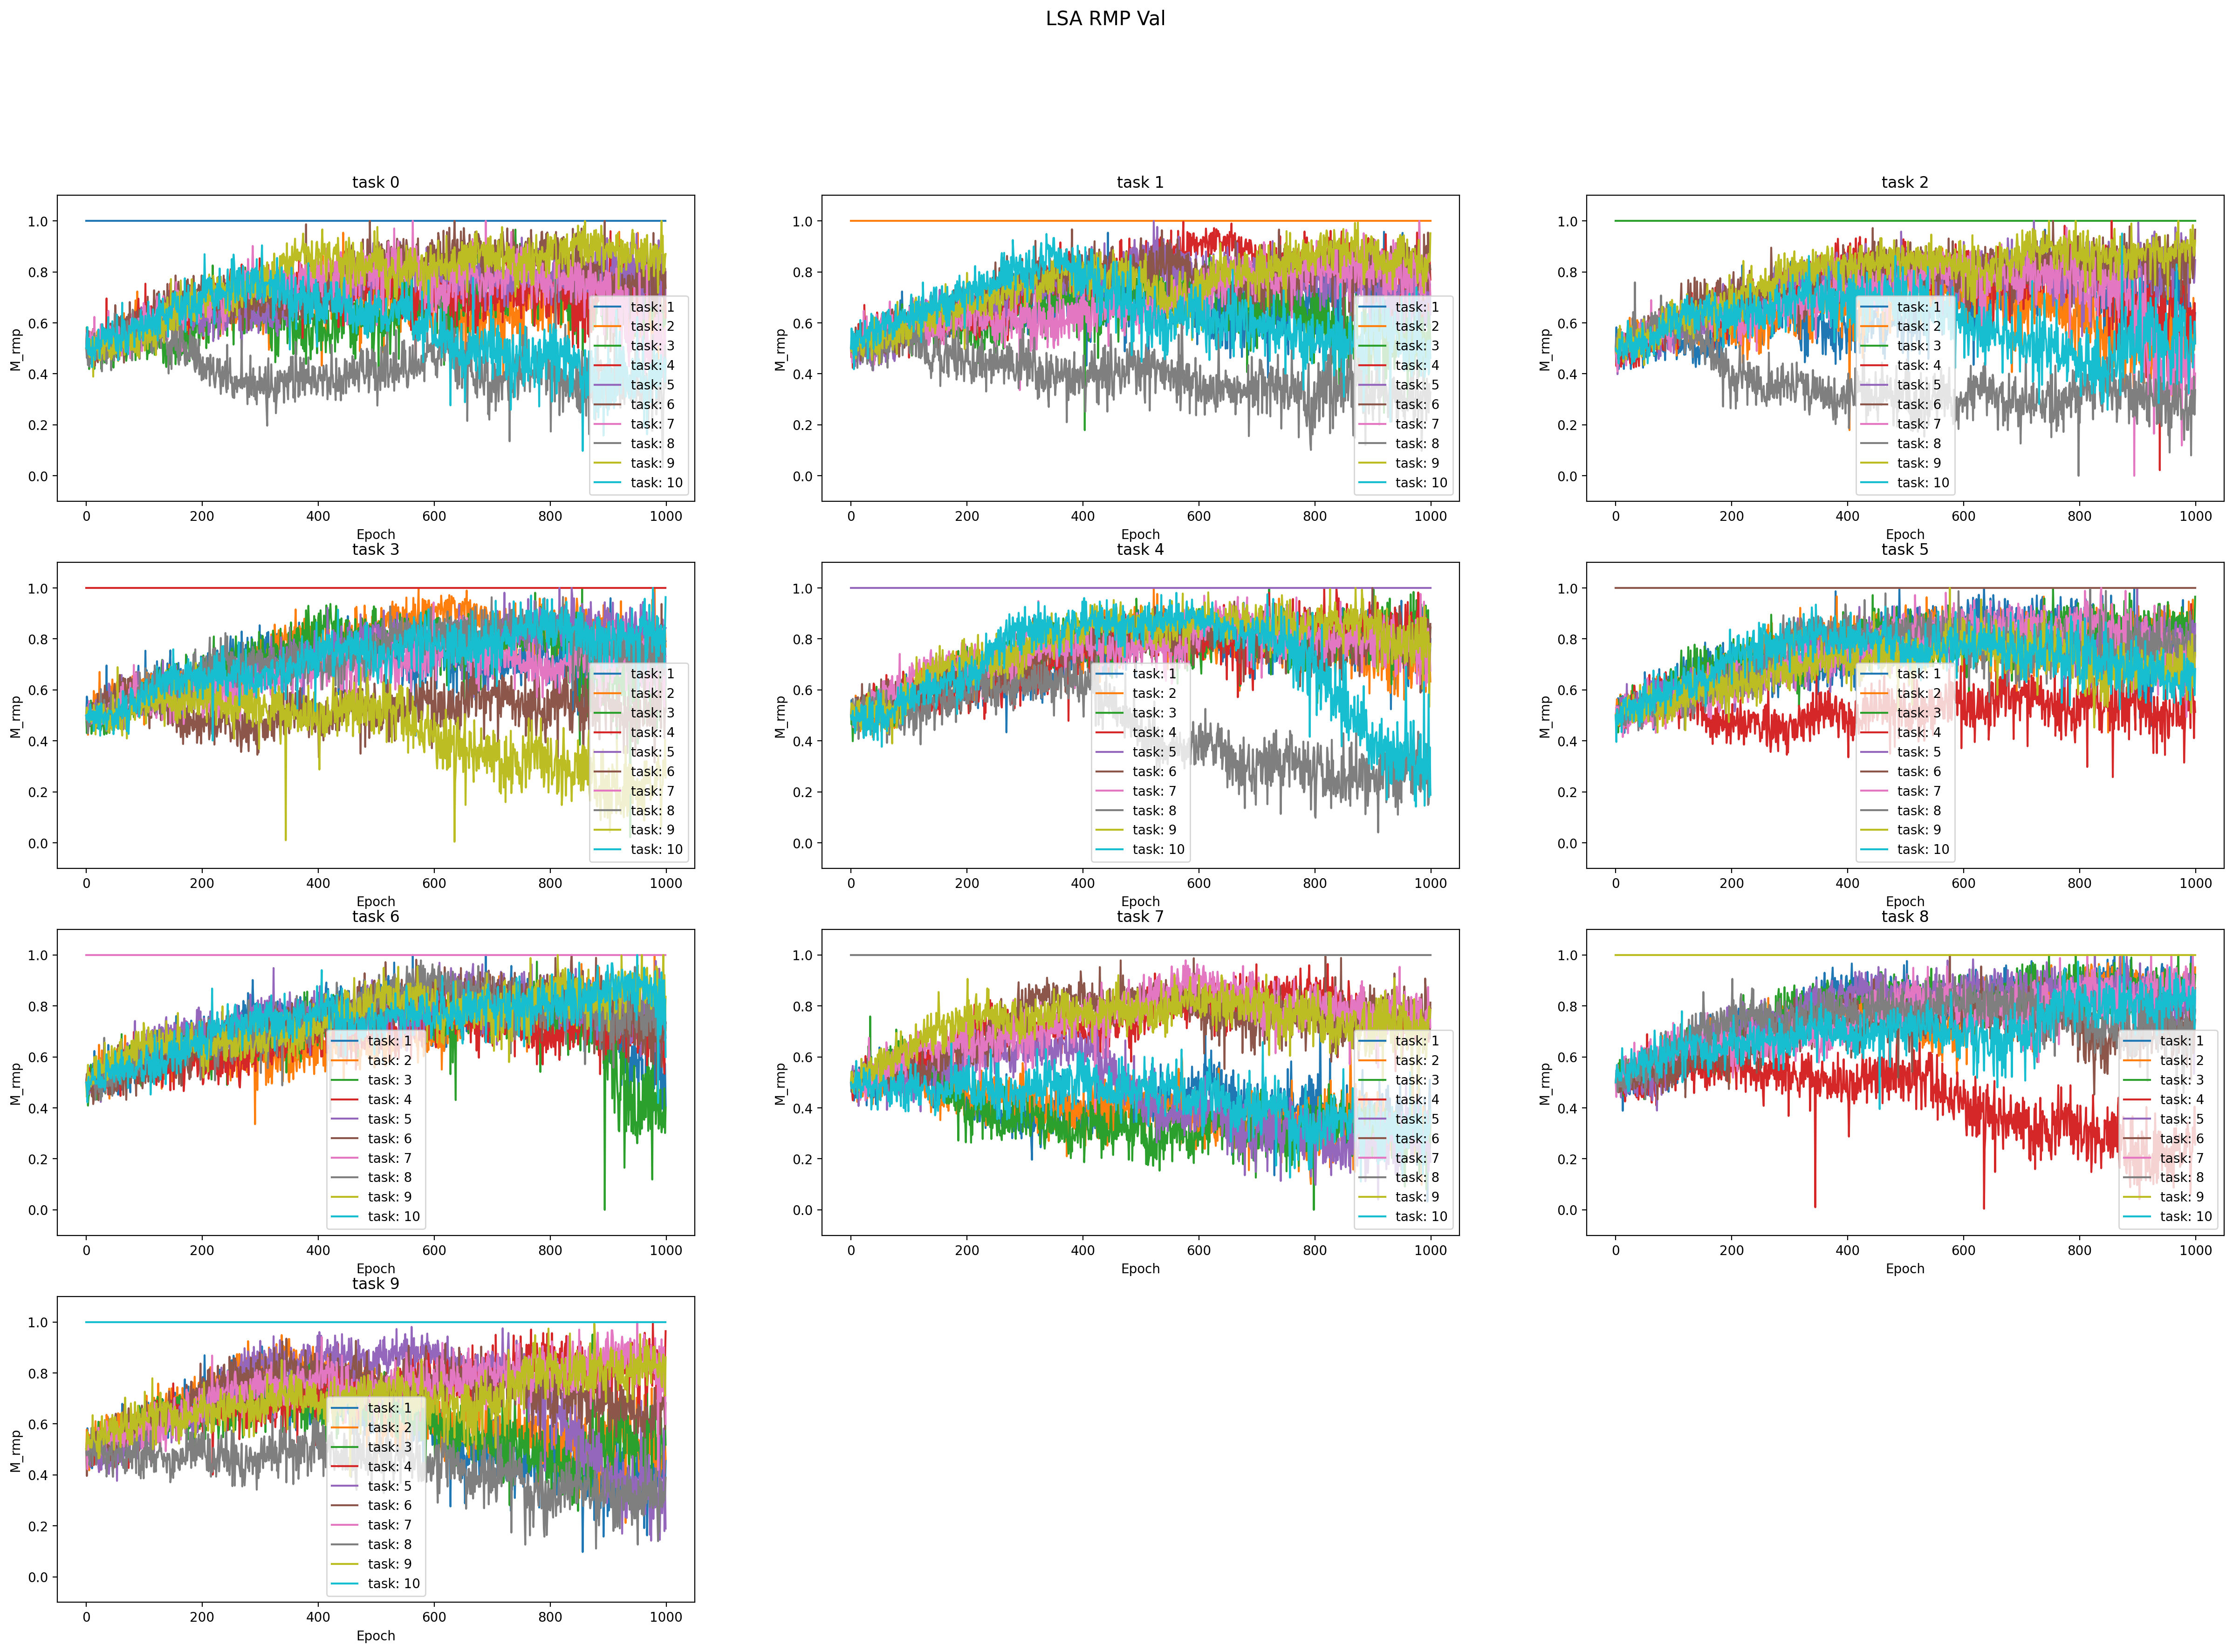

In [18]:
fig = plt.figure(figsize = (30, 20), dpi= 200)
fig.suptitle("LSA RMP Val\n", size = 15)
fig.set_facecolor("white")

for i in range (len(tasks)):
    for j in range (len(tasks)):
        r, c = min(i, j), max(i, j)
        if i != j: 
            plt.subplot(int(np.ceil(len(tasks) / 3)), 3, i + 1)
            plt.plot(np.arange(1000), np.array(lsa_rmp_his[r][c])[:1000, 0], label= 'task: ' +str(j + 1))
            plt.legend()
        else:
            plt.subplot(int(np.ceil(len(tasks) / 3)), 3, i + 1)
            plt.plot(np.arange(1000), np.ones_like(np.arange(1000)), label= 'task: ' +str(j + 1))
            plt.legend()



    plt.title('task ' + str( i))
    plt.xlabel("Epoch")
    plt.ylabel("M_rmp")
    plt.ylim(bottom = -0.1, top = 1.1)


#### GECCO 20


In [19]:
ID = 1
gecco_tasks = GECCO20_benchmark_50tasks(ID)

In [20]:
mfea_sol, mfea_his = MFEA1(num_epochs= 1000, num_inds_each_task= 100, tasks = gecco_tasks,
                        rmp = 0.3, nc = 2, nm = 5, evaluate_initial_skillFactor= True,
                        one_line=True, num_epochs_printed=10 )

np.save(file = "./RESULTS/mfea_base_his_GECCO20_" + str(ID) + ".npy", arr = mfea_his )

Epoch [1000/1000], [====================>] 100% ,func_val: [0.31504682911355125, 0.2982664252848364, 0.31092839925657956, 0.3097624378865757, 0.29176862665222275, 0.3220656499025702, 0.3173991324768258, 0.3131797255972626, 0.32867350768346104, 0.30961861087965, 0.3198611561280637, 0.3017203912574908, 0.3027921307427867, 0.32528741588510285, 0.311520678347287, 0.31501236009066197, 0.2931691305660016, 0.30589710842522455, 0.2976743073360607, 0.2852971788177183, 0.2868603517347774, 0.3038215058389613, 0.30630170642179844, 0.3023052956758464, 0.30465087821220216, 0.31738183319888613, 0.3108781287212689, 0.3027208034480358, 0.3076955126179085, 0.3104558433686319, 0.31745978774092853, 0.3103291930607402, 0.3207111345369425, 0.30542459872600625, 0.2761054484936006, 0.3182913496392731, 0.31533531304549994, 0.3264747034374975, 0.3104793059284114, 0.3072967066471881, 0.3019808577812106, 0.3096295183611728, 0.30109290245577464, 0.3241118405195215, 0.30701701397792724, 0.3128905276979219, 0.305898

TypeError: can only concatenate str (not "int") to str

In [22]:
sa_sol, sa_his, sa_rmp_his = LSA_MFEA(100000 * len(gecco_tasks), LSA = False, num_inds_each_task= 100, tasks= gecco_tasks,
                                    nc = 2, nm = 5, H = 30, sigmoid= 0.1)

np.save(file = "./RESULTS/sa_his_GECCO20_" +  str(ID) + ".npy", arr = sa_his)
np.save(file = "./RESULTS/sa_rmp_his_GECCO20_" +  str(ID) + ".npy", arr = sa_rmp_his )

Epoch 1000, [====================>] 100% ,pop_size: 5000, func_val: [0.4334654257729865, 0.43545311354027577, 0.433607104704898, 0.42623889473703114, 0.4238340389050627, 0.4231216363491606, 0.429128774315389, 0.4288556351317649, 0.43568831419466164, 0.4065065107564036, 0.43398908746804804, 0.4381076320465648, 0.4398283766663427, 0.4353976333675665, 0.4375162704373343, 0.41615795378351067, 0.42290149597449295, 0.4328402361367091, 0.4200676696340645, 0.3984803928950148, 0.4448361202864682, 0.4445662782541251, 0.3980262912153043, 0.43209125530923875, 0.4405195599814174, 0.43565645501179, 0.44929001035778343, 0.4285089832192397, 0.4316385535260773, 0.4127945831964783, 0.4253838881148868, 0.39035433733019426, 0.3935403057747394, 0.4257738581543004, 0.42663964673741633, 0.4353729836643106, 0.4349611961240854, 0.43486216159192637, 0.4232983306570872, 0.4177208595507984, 0.424985210930115, 0.43362406157844613, 0.42987119152900144, 0.41690739854203746, 0.44910576861724805, 0.4466157569607972, 0

/tmp/ipykernel_399610/35088251.py:188: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return sol, history_cost, np.array(saved_rmp)


In [23]:
lsa_sol, lsa_his, lsa_rmp_his = LSA_MFEA(80000 * len(gecco_tasks), num_inds_each_task= 100, tasks= gecco_tasks, 
                                        nc = 2, nm = 5, H = 30, sigmoid= 0.1)
np.save(file = "./RESULTS/lsa_his_GECCO20_" +  str(ID) + ".npy", arr = lsa_his)
np.save(file = "./RESULTS/lsa_rmp_his_GECCO20_" +  str(ID) + ".npy", arr = lsa_rmp_his )

Epoch 1117, [====================>] 100% ,pop_size: 2467, func_val: [0.23115878724603686, 0.23141107319107562, 0.2307213144470124, 0.20588378596524895, 0.22885068945950857, 0.21404637321121148, 0.21709704180733055, 0.23356404125054606, 0.19762590492079132, 0.22379362042524, 0.2346764885235514, 0.2065296246750529, 0.20990933228957326, 0.20162469324001753, 0.21201235781959918, 0.19918498858017306, 0.2173278405411389, 0.2235653836573477, 0.24019517083058436, 0.22166600995229171, 0.2394853016654696, 0.21516464623134413, 0.2326479247078976, 0.20582849529131025, 0.20273874162608357, 0.23236089306195656, 0.23538077724179612, 0.22992613166717876, 0.2288368240578734, 0.23630300502228407, 0.22060478306373846, 0.23167191952817237, 0.21089457418166235, 0.2268617466290687, 0.207357629007067, 0.22678767531873104, 0.22995027249614172, 0.23090601247606848, 0.19010087394052658, 0.20703481087063064, 0.23648017969301835, 0.214864938236161, 0.22937644649529024, 0.2238893492153874, 0.21577999782704183, 0.2

/tmp/ipykernel_399610/35088251.py:188: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return sol, history_cost, np.array(saved_rmp)
